In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.integrate import quad
from scipy.fft import fft, ifft
from scipy.interpolate import interp1d
import scipy.integrate as integrate
from functools import partial
from scipy.optimize import minimize, fsolve, basinhopping
import tqdm
import yfinance as yf
import yahoo_fin.options as ops
import cmath
from numba import jit, cuda, njit

%matplotlib inline

plt.style.use('ggplot')
sns.set_palette('mako')
sns.set_style('darkgrid')

In [2]:
import exact_methods as exm
import characteristics_functions as chf
import monte_carlo_methods as mcm
import stochastic_processes as stch

In [3]:
expiration_dates = ops.get_expiration_dates("aapl")

In [4]:
expiration_dates

['May 6, 2022',
 'May 13, 2022',
 'May 20, 2022',
 'May 27, 2022',
 'June 3, 2022',
 'June 17, 2022',
 'July 15, 2022',
 'August 19, 2022',
 'September 16, 2022',
 'October 21, 2022',
 'November 18, 2022',
 'January 20, 2023',
 'March 17, 2023',
 'June 16, 2023',
 'September 15, 2023',
 'January 19, 2024',
 'June 21, 2024']

In [5]:
# s0_apple = 150.62 #15.03.2022
apple = yf.Ticker('AAPL')
s0 = apple.history().iloc[-1, 3]
s0

157.64999389648438

In [6]:
apple_option_calls = ops.get_calls("AAPL", expiration_dates[3])

In [7]:
apple_option_calls.head()

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility
0,AAPL220527C00100000,2022-04-28 9:48AM EDT,100.0,59.90,57.50,58.05,0.00,-,14,20,75.98%
1,AAPL220527C00110000,2022-04-27 1:19PM EDT,110.0,48.50,47.55,48.10,0.00,-,40,45,64.75%
2,AAPL220527C00115000,2022-04-29 10:08AM EDT,115.0,49.95,42.60,43.15,7.95,+18.93%,1,2,60.06%
3,AAPL220527C00120000,2022-04-28 11:24AM EDT,120.0,42.07,37.70,38.10,0.00,-,1,21,54.00%
4,AAPL220527C00125000,2022-04-29 2:47PM EDT,125.0,34.84,32.85,33.25,-4.26,-10.90%,3,3,51.51%


In [8]:
# apple_option_calls.to_csv('apple_option_call_may_20_2022_s0163_639.csv')

In [9]:
apple_strikes = apple_option_calls.loc[:, 'Strike']
apple_market_price = apple_option_calls.loc[:, 'Last Price']

In [10]:
apple_spread = apple_option_calls.loc[:, 'Ask'] - apple_option_calls.loc[:, 'Bid']

In [11]:
from datetime import datetime

In [12]:
expr_date = datetime.strptime(expiration_dates[3], '%B %d, %Y')
expr_date

datetime.datetime(2022, 5, 27, 0, 0)

In [13]:
today_date = datetime.now()
today_date

datetime.datetime(2022, 5, 1, 14, 1, 8, 588733)

In [14]:
maturity = expr_date - today_date
maturity = maturity.days/365.25
maturity

0.06844626967830253

In [15]:
(expr_date - today_date).days

25

In [47]:
from datetime import datetime

apple_option_calls = pd.read_csv('apple_option_call_may_20_2022_s0163_639.csv')
apple_strikes = apple_option_calls.loc[:, 'Strike']
apple_market_price = apple_option_calls.loc[:, 'Last Price']

In [48]:
expr_date = datetime.strptime('May 20, 2022', '%B %d, %Y')

In [49]:
maturity = expr_date - datetime.strptime('May 1, 2022', '%B %d, %Y')
maturity = maturity.days/365.25
maturity

0.05201916495550993

In [50]:
s0 = 163.639

K = apple_strikes

marketPrice = apple_market_price

In [51]:
N = 500
T = maturity
r = 0.05
rho1 = 0.01

type_option = 'c'
# type_option = 'p'

In [52]:
# r, kappa, gamma, vbar, v0, rho

def error_fHM(x, prices, strikes, s0):
    cf = chf.ChFHestonModel(x[0], 1, x[1], x[2], x[3], x[4], x[5])
    
    price_calib = exm.CallPutOptionPriceCOS(cf, type_option, s0, x[0], T, strikes, N, 8).T[0]
#     errorVector = (price_calib - prices)
    errorVector = np.mean(((price_calib - prices))**2)
    
#     value = np.linalg.norm(errorVector)
    value = errorVector
    return value

In [53]:
init_vals = [0.05, 2, 0.3, 0.4, 0.3, -0.7]
bounds = ((0.001, 0.3), (0.001, 4), (0.0001, 2), (0.0001, 1.5), (0.0001, 1.5), (-0.9, 0.9))

# P0T = lambda T: np.exp(0.0012*T+0.0007) 
# s0 = 174.62

# referenceIV = np.array([48.53, 24.49, 19.23])/100.0
        
# T = 5/365.25
# referenceIV = np.array([36.76, 29.18, 27.66])/100.0
    
# frwd = s0/P0T(T)
# K = [0.4*frwd, frwd, 1.2*frwd]
# K = np.array(K).reshape([len(K),1])
      
# referenceIV = np.array(referenceIV).reshape([len(referenceIV),1])
# marketPrice = P0T(T)* exm.BS_Call_Option_Price('c', s0 / P0T(T), K, referenceIV, T, 0)


# params_heston_COS = minimize(error_fHM, x0=init_vals, args=(apple_market_price, apple_strikes, s0_apple, apple_spread),
#                              bounds=bounds, tol=1e-4, options={"maxiter": 1000})

K = apple_strikes
marketPrice = apple_market_price

params_heston_COS = minimize(error_fHM, x0=init_vals, args=(marketPrice, K, s0),
                             bounds=bounds, tol=1e-4, options={"maxiter": 1000})

params_heston_COS

      fun: 10.305987666229184
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([85.6808752 ,  0.18152875,  0.21670825,  1.70240124, 10.73802487,
       -1.84291106])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 105
      nit: 10
     njev: 15
   status: 0
  success: True
        x: array([ 1.00000000e-03,  5.39992597e-01,  1.54321267e+00,  1.05708684e-01,
        1.00000000e-04, -8.05833264e-01])

In [54]:
np.sqrt(params_heston_COS.fun)

3.210294015542686

In [55]:
r, kappa, gamma, vbar, v0, rho = params_heston_COS.x

In [56]:
cf = chf.ChFHestonModel(r, 1, kappa, gamma, vbar, v0, rho)
option_heston_cos = exm.CallPutOptionPriceCOS(cf, type_option, s0, r, T, K, N, 10).T[0]

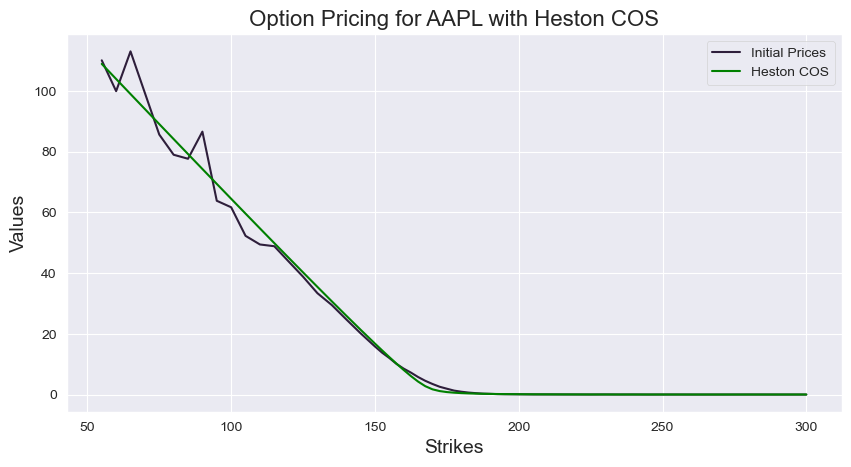

In [57]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(K, marketPrice, label='Initial Prices')
plt.plot(K, option_heston_cos, color='green', label='Heston COS')
        
plt.title('Option Pricing for AAPL with Heston COS', fontsize=16)
plt.xlabel('Strikes', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend()
plt.show()

In [14]:
def calibrationBates_SIR_SC(CP, xip, K, marketPrice, s0, T):
    K = np.array(K)
    marketPrice = np.array(marketPrice)
    
    # x = [k, gamma, vb, gammar, mur, murho, sigmarho, rho4, rho5, v0, kr, krho, rho0, r0, muJ, sigmaJ]
    f_obj = lambda x: errorFun(CP, tau, T, x[0], x[1], x[2], x[10], x[3], x[4], x[11], x[5], x[6], x[7], x[8], xip, x[14],
                               x[15], x[9], x[13], x[12], K, marketPrice, s0)

    #[k, gamma, vb, gammar, mur, murho, sigmarho, rho4, rho5, v0, kr, krho, rho0, r0, muJ, sigmaJ]
    initial = np.array([0.4, 0.3, 0.04, 0.3, 0.1, 0.2, 0.5, 0.1, 0.1, 0.05, 0.4, 0.5, -0.7, 0.001, 0, 1])
#     pars  = minimize(f_obj, initial, method='nelder-mead', options = {'xtol': 1e-05, 'disp': False,'maxiter':1000})
    
    xmin = [0.001, 0.0001, 0.0001, 0.0005, 0.001, 0.0001, 0.0005, -0.99, -0.99, 0.0001, 0.0001, 0.4, -1, 0.0001, -10, 0.0001]
#     xmax = [2, 0.3, 0.4, 0.3, 0.4, 0.4, 0.2, 0.8, 0.8, 0.3, 0.99, 0.99]  
    xmax = [5, 0.7, 1.5, 2, 3, 2, 1, 0.6, 0.9, 1.7, 4, 5, 1, 0.3, 10, 15] 
    
    bounds = [(low, high) for low, high in zip(xmin, xmax)]
    
    minimizer_kwargs = dict(method="L-BFGS-B", bounds=bounds)

#     # Global search
#     pars = basinhopping(f_obj, initial, niter=1, minimizer_kwargs=minimizer_kwargs)
    
#     k_est = pars.x[0]
#     gamma_est = pars.x[1]
#     vb_est = pars.x[2]
#     gammar_est = pars.x[3]
#     mur_est = pars.x[4]
#     murho_est = pars.x[5]
#     sigmarho_est = pars.x[6]
#     rho4_est = pars.x[7]
#     rho5_est = pars.x[8]
#     v0_est = pars.x[9]
#     kr_est = pars.x[10]
#     krho_est = pars.x[11]
#     rho0 = pars.x[12]
#     r0 = pars.x[13]
#     muJ = pars.x[14]
#     sigmaJ = pars.x[15]

#     print(f'Initial guess: {pars.x}', pars.fun)

# #     Use global parameters in the local search
#     initial = [k_est, gamma_est, vb_est, gammar_est, mur_est, murho_est, sigmarho_est, rho4_est, rho5_est, v0_est, kr_est, krho_est, rho0, r0,
#                   muJ, sigmaJ] 
    
    pars  = minimize(f_obj, x0=initial, tol=1e-8, bounds=bounds, options = {'maxiter': 200, 'disp':False})
#     pars  = minimize(f_obj, x0=initial, method='nelder-mead', tol=1e-6, options = {'maxiter': 100, 'disp':False})
    print(pars)
    
    k_est = pars.x[0]
    gamma_est = pars.x[1]
    vb_est = pars.x[2]
    gammar_est = pars.x[3]
    mur_est = pars.x[4]
    murho_est = pars.x[5]
    sigmarho_est = pars.x[6]
    rho4_est = pars.x[7]
    rho5_est = pars.x[8]
    v0_est = pars.x[9]
    kr_est = pars.x[10]
    krho_est = pars.x[11]
    rho0_est = pars.x[12]
    r0_est = pars.x[13]
    muJ_est = pars.x[14]
    sigmaJ_est = pars.x[15]
    
    parmCalibr =  {"k":k_est, "gamma":gamma_est, "vb":vb_est, "gammar":gammar_est, "mur":mur_est, "murho":murho_est, \
                   "sigmarho":sigmarho_est, "rho4":rho4_est, "rho5": rho5_est, "v0":v0_est, "kr": kr_est, "krho": krho_est, \
                   "rho0": rho0_est, "r0": r0_est, "muJ": muJ_est, "sigmaJ": sigmaJ_est, 'ErrorFinal':pars.fun}
    return parmCalibr

In [15]:
def errorFun(CP, tau, T, k, gamma, vb, kr, gammar, mur, krho, murho, sigmarho, rho4, rho5, xip, muJ, sigmaJ, v0, r0, rho0, K, marketPrice, s0):
    if K is not np.array:
        K = np.array(K).reshape([len(K),1])

    N = 500
    L = 10
    cf = chf.ChFBates_StochIR_StochCor(tau, T, k, gamma, vb, kr, gammar, mur, krho, murho, sigmarho, rho4, rho5, xip, muJ, sigmaJ, v0, r0, rho0)
    valCOS = exm.optionPriceCOSMthd_StochIR(cf, CP, s0, T, K, N, L)

    errorVector = np.mean((valCOS.T[0] - marketPrice)**2)
#     errorVector = valCOS - marketPrice
    value = errorVector
#     value = np.linalg.norm(errorVector)

    return value

In [16]:
T = maturity
tau = T
# s0 = 174.62
xip = 0.05
type_option = 'c'

# P0T = lambda T: np.exp(0.0005*T)

# dt = 0.0001 
# # P0T = lambda T: np.exp(0.0012*T+0.0007) 
# f0T = lambda t: - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2.0*dt)
# r0 = f0T(0.00001)

K = apple_strikes

marketPrice = apple_market_price

calibratedParms =  calibrationBates_SIR_SC(type_option, xip, K, marketPrice, s0, T)

k = calibratedParms.get('k')
gamma = calibratedParms.get('gamma')
vb = calibratedParms.get('vb')
gammar = calibratedParms.get('gammar')
mur = calibratedParms.get('mur')
murho = calibratedParms.get('murho')
sigmarho = calibratedParms.get('sigmarho')
rho4 = calibratedParms.get('rho4')
rho5 = calibratedParms.get('rho5')
v0 = calibratedParms.get('v0')
kr = calibratedParms.get('kr')
krho = calibratedParms.get('krho')
rho0 = calibratedParms.get('rho0')
r0 = calibratedParms.get('r0')
muJ = calibratedParms.get('muJ')
sigmaJ = calibratedParms.get('sigmaJ')

errorFinal = calibratedParms.get('ErrorFinal') 

      fun: 9.472449605613965
 hess_inv: <16x16 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.67688087e-04, -2.91759504e-02,  9.67761160e-01,  4.44089210e-06,
       -3.19744231e-06,  1.74971149e-04, -1.41042733e-04, -1.07061027e-03,
        1.90070182e-05,  8.33560776e-02, -2.66453526e-06,  3.66284780e-04,
        2.06959782e-02,  1.10686287e+00, -5.19477797e-03, -4.26325641e-06])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 289
      nit: 13
     njev: 17
   status: 0
  success: True
        x: array([ 4.99795088e+00,  6.80675908e-01,  1.86163395e-03,  2.98646494e-01,
        9.96467327e-02,  1.99075411e-01,  4.99647011e-01,  9.79480072e-02,
        9.58610895e-02,  1.96635674e-01,  4.00281603e-01,  4.98399124e-01,
       -8.02820919e-01,  1.00000000e-04, -1.78758879e+00,  5.38525410e-04])


In [17]:
np.sqrt(errorFinal)

3.077734492384612

In [18]:
round(errorFinal, 9)

9.472449606

In [19]:
L = 10
N = 500

cf = chf.ChFBates_StochIR_StochCor(tau, T, k, gamma, vb, kr, gammar, mur, krho, murho, sigmarho, rho4, rho5, xip, muJ, sigmaJ, v0, r0, rho0)
valCOS = exm.optionPriceCOSMthd_StochIR(cf, type_option, s0, T, K, N, L)

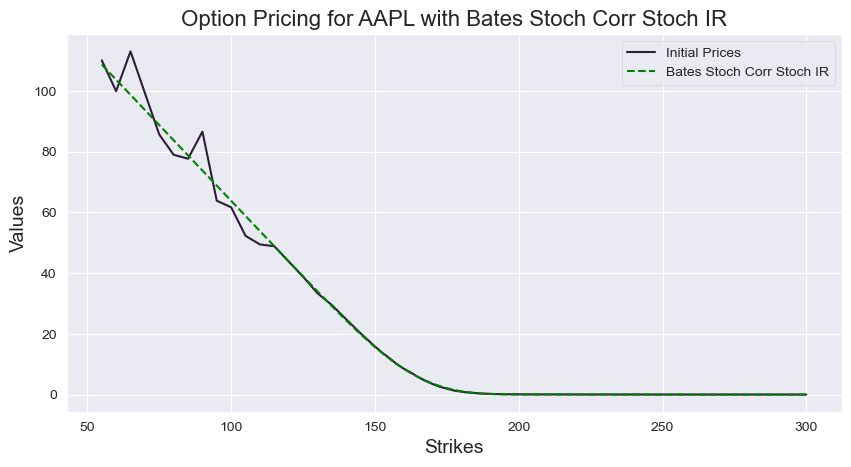

In [20]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(K, marketPrice, label='Initial Prices')
plt.plot(K, valCOS, '--', color='green', label='Bates Stoch Corr Stoch IR')
        
plt.title('Option Pricing for AAPL with Bates Stoch Corr Stoch IR', fontsize=16)
plt.xlabel('Strikes', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend()
plt.show()

In [21]:
print(f'r0: {r0}, v0: {v0}, rho0: {rho0}, muJ: {muJ}, sigmaJ: {sigmaJ}')

r0: 0.0001, v0: 0.19663567426729445, rho0: -0.8028209194900608, muJ: -1.7875887918800268, sigmaJ: 0.0005385254098794113


In [22]:
np.mean((marketPrice.values - valCOS.T[0])**2)

9.472449605613965

In [23]:
list_params = np.array([v0, k, gamma, vb, kr, gammar, mur, krho, murho, sigmarho, rho4, rho5, muJ, sigmaJ, r0, rho0, xip])
pd.DataFrame(list_params.reshape(1, -1), columns=['v0', 'k', 'gamma', 'vb', 'kr', 'gammar', 'mur', 'krho', 'murho', 'sigmarho', 'rho4', 'rho5', 'muJ', 'sigmaJ', 'r0', 'rho0', 'xip'])

,v0,k,gamma,vb,kr,gammar,mur,krho,murho,sigmarho,rho4,rho5,muJ,sigmaJ,r0,rho0,xip
0,0.196636,4.997951,0.680676,0.001862,0.400282,0.298646,0.099647,0.498399,0.199075,0.499647,0.097948,0.095861,-1.787589,0.000539,0.0001,-0.802821,0.05


Optimal parameters for H1-HW are: gamma = 0.778, vBar = 0.094, Rxv = -0.688, v0 = 0.201
Final error for H1HW = 9.442963196


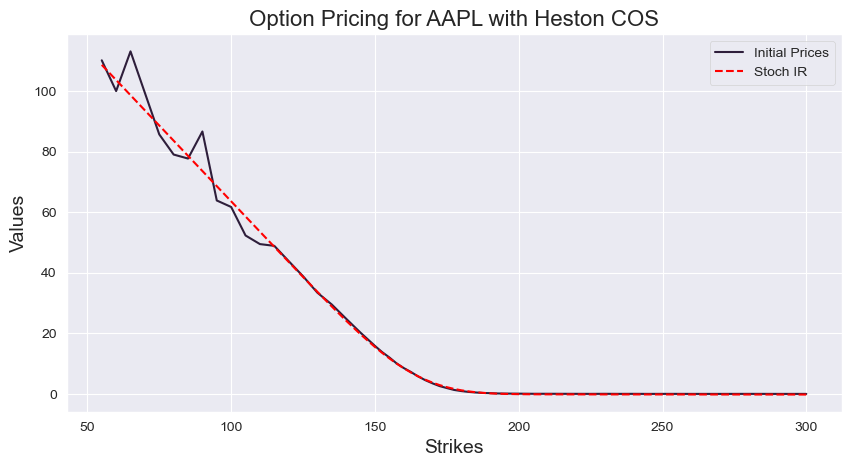

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.stats as st
import scipy.special as sp
import enum 
import scipy.optimize as optimize
from scipy.optimize import minimize

i   = complex(0.0,1.0)

# Time step 
dt = 0.0001

class OptionType(enum.Enum):
    CALL = 1.0
    PUT = -1.0
    
def CallPutOptionPriceCOSMthd_StochIR(cf,CP,S0,tau,K,N,L,P0T):


    # cf   - Characteristic function is a function, in the book denoted by \varphi
    # CP   - C for call and P for put
    # S0   - Initial stock price
    # tau  - Time to maturity
    # K    - List of strikes
    # N    - Number of expansion terms
    # L    - Size of truncation domain (typ.:L=8 or L=10)
    # P0T  - Zero-coupon bond for maturity T.

    # Reshape K to become a column vector

    if K is not np.array:
        K = np.array(K).reshape([len(K),1])
    
    # Assigning i=sqrt(-1)

    i = complex(0.0,1.0) 
    x0 = np.log(S0 / K)   
    
    # Truncation domain

    a = 0.0 - L * np.sqrt(tau)
    b = 0.0 + L * np.sqrt(tau)
    
    # Summation from k = 0 to k=N-1

    k = np.linspace(0,N-1,N).reshape([N,1])  
    u = k * np.pi / (b - a)  

    # Determine coefficients for put prices  

    H_k = CallPutCoefficients(OptionType.PUT,a,b,k)   
    mat = np.exp(i * np.outer((x0 - a) , u))
    temp = cf(u) * H_k 
    temp[0] = 0.5 * temp[0]    
    value = K * np.real(mat.dot(temp))     
    
    # We use the put-call parity for call options

    if CP == OptionType.CALL:
        value = value + S0 - K * P0T
        
    return value

# Determine coefficients for put prices 

def CallPutCoefficients(CP,a,b,k):
    if CP==OptionType.CALL:                  
        c = 0.0
        d = b
        coef = Chi_Psi(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        if a < b and b < 0.0:
            H_k = np.zeros([len(k),1])
        else:
            H_k      = 2.0 / (b - a) * (Chi_k - Psi_k)  
    elif CP==OptionType.PUT:
        c = a
        d = 0.0
        coef = Chi_Psi(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        H_k      = 2.0 / (b - a) * (- Chi_k + Psi_k)               
    
    return H_k    

def Chi_Psi(a,b,c,d,k):
    psi = np.sin(k * np.pi * (d - a) / (b - a)) - np.sin(k * np.pi * (c - a)/(b - a))
    psi[1:] = psi[1:] * (b - a) / (k[1:] * np.pi)
    psi[0] = d - c
    
    chi = 1.0 / (1.0 + np.power((k * np.pi / (b - a)) , 2.0)) 
    expr1 = np.cos(k * np.pi * (d - a)/(b - a)) * np.exp(d)  - np.cos(k * np.pi 
                  * (c - a) / (b - a)) * np.exp(c)
    expr2 = k * np.pi / (b - a) * np.sin(k * np.pi * 
                        (d - a) / (b - a))   - k * np.pi / (b - a) * np.sin(k 
                        * np.pi * (c - a) / (b - a)) * np.exp(c)
    chi = chi * (expr1 + expr2)
    
    value = {"chi":chi,"psi":psi }
    return value
    
# Black-Scholes call option price

def meanSqrtV_3(kappa,v0,vbar,gamma):
    delta = 4.0 *kappa*vbar/gamma/gamma
    c= lambda t: 1.0/(4.0*kappa)*gamma*gamma*(1.0-np.exp(-kappa*(t)))
    kappaBar = lambda t: 4.0*kappa*v0*np.exp(-kappa*t)/(gamma*gamma*(1.0-np.exp(-kappa*t)))
    temp1 = lambda t: np.sqrt(2.0*c(t))* sp.gamma((1.0+delta)/2.0)/sp.gamma(delta/2.0)*sp.hyp1f1(-0.5,delta/2.0,-kappaBar(t)/2.0)
    return temp1

def C_H1HW(u,tau,lambd):
    i = complex(0.0,1.0)
    C = (i*u - 1.0)/lambd * (1-np.exp(-lambd*tau))
    return C

def D_H1HW(u,tau,kappa,gamma,rhoxv):
    i = complex(0.0,1.0)
    
    D1 = np.sqrt(np.power(kappa-gamma*rhoxv*i*u,2)+(u*u+i*u)*gamma*gamma)
    g  = (kappa-gamma*rhoxv*i*u-D1)/(kappa-gamma*rhoxv*i*u+D1)
    D  = (1.0-np.exp(-D1*tau))/(gamma*gamma*(1.0-g*np.exp(-D1*tau)))\
        *(kappa-gamma*rhoxv*i*u-D1)
    return D
    
def A_H1HW(u,tau,P0T,lambd,eta,kappa,gamma,vbar,v0,rhoxv,rhoxr):
    i  = complex(0.0,1.0)
    D1 = np.sqrt(np.power(kappa-gamma*rhoxv*i*u,2)+(u*u+i*u)*gamma*gamma)
    g  = (kappa-gamma*rhoxv*i*u-D1)/(kappa-gamma*rhoxv*i*u+D1)
    
    # Function theta(t)

    dt = 0.0001    
    f0T = lambda t: - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2.0*dt)
    theta = lambda t: 1.0/lambd * (f0T(t+dt)-f0T(t-dt))/(2.0*dt) + f0T(t) + eta*eta/(2.0*lambd*lambd)*(1.0-np.exp(-2.0*lambd*t))  

    # Integration within the function I_1

    N  = 500
    z  = np.linspace(0,tau-1e-10,N)
    f1 = (1.0-np.exp(-lambd*z))*theta(tau-z)
    value1 = integrate.trapz(f1,z)
    
    # Note that I_1_adj also allows time-dependent theta 
    # Therefore it is not exactly the same as in the book

    I_1_adj = (i*u-1.0) * value1
    I_2     = tau/(gamma**2.0) *(kappa-gamma*rhoxv*i*u-D1) - 2.0/(gamma**2.0)*np.log((1.0-g*np.exp(-D1*tau))/(1.0-g))
    I_3     = 1.0/(2.0*np.power(lambd,3.0))* np.power(i+u,2.0)*(3.0+np.exp(-2.0*lambd*tau)-4.0*np.exp(-lambd*tau)-2.0*lambd*tau)
    
    meanSqrtV = meanSqrtV_3(kappa,v0,vbar,gamma)
    f2        = meanSqrtV(tau-z)*(1.0-np.exp(-lambd*z))
    value2    = integrate.trapz(f2,z)
    I_4       = -1.0/lambd * (i*u+u**2.0)*value2
    
    return I_1_adj + kappa*vbar*I_2 + 0.5*eta**2.0*I_3+eta*rhoxr*I_4

def ChFH1HWModel(P0T,lambd,eta,tau,kappa,gamma,vbar,v0,rhoxv, rhoxr):
    dt = 0.0001    
    f0T = lambda t: - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2.0*dt)
    r0 =f0T(0.00001)
    C = lambda u: C_H1HW(u,tau,lambd)
    D = lambda u: D_H1HW(u,tau,kappa,gamma,rhoxv)
    A = lambda u: A_H1HW(u,tau,P0T,lambd,eta,kappa,gamma,vbar,v0,rhoxv,rhoxr)
    cf = lambda u: np.exp(A(u) + C(u)*r0 + D(u)*v0 )
    return cf


def calibrationH1HW_Global(CP,K,marketPrice,S0,T,P0T):
    K = np.array(K)
    marketPrice = np.array(marketPrice)
    # x = [gamma,vBar,Rxv,v0, eta, kappa, lambda, rxr]
    f_obj = lambda x: TargetValH1HW(CP,x[5],x[0],x[1],x[7],x[2],x[3],x[4],x[6],K,marketPrice,S0,T,P0T)
       
    # Random initial guess

    #[gamma,vBar,Rxv,v0]
    initial = np.array([1.0, 0.05,-0.7, 0.05, 0.01, 0.3, 0.04, 0.4])
    
    # The bounds

    xmin = [0.001, 0.001,-0.99, 0.001, 0.001, 0.001, 0.001, -1]
    xmax = [0.8,  0.8,  -0.1, 0.8, 0.7, 0.7, 0.7, 1]    
    
    # Rewrite the bounds as required by L-BFGS-B

    bounds = [(low, high) for low, high in zip(xmin, xmax)]

    pars  = minimize(f_obj,initial,bounds=bounds, tol=1e-05)
    
    gamma_est = pars.x[0]
    vBar_est = pars.x[1]
    Rxv_est = pars.x[2]
    v0_est = pars.x[3]
    eta = pars.x[4]
    kappa = pars.x[5]
    lambd = pars.x[6]
    rxr = pars.x[7]
    parmCalibr =  {"gamma":gamma_est,"vBar":vBar_est,"Rxv":Rxv_est,\
                   "v0":v0_est, "eta": eta, "kappa": kappa, "lambda": lambd, "rxr": rxr,'ErrorFinal':pars.fun}
    return parmCalibr

def TargetValH1HW(CP,kappa,gamma,vBar,Rxr,Rxv,v0,eta,lambd,K,marketPrice,S0,T,P0T):
    if K is not np.array:
        K = np.array(K).reshape([len(K),1])
    
    # Settings for the COS method

    N = 500
    L = 10 
    cf = ChFH1HWModel(P0T,lambd,eta,T,kappa,gamma,vBar,v0, Rxv, Rxr)
    valCOS = CallPutOptionPriceCOSMthd_StochIR(cf, CP, S0, T, K, N, L,P0T(T))
    
    # Error is defined as the difference between the market and the model

    errorVector = np.mean((valCOS.T[0] - marketPrice)**2)
    
    # Target value is a norm of the error vector

#     value       = np.linalg.norm(errorVector)   
    value = errorVector
    return value

def mainCalculation():
    CP  = OptionType.CALL
    global valCOS_H1HW
        
#     S0    = 174.62    
    S0 = s0


    P0T = lambda T: np.exp(0.0012*T+0.0007)

    N = 500
    L = 10 

    
    T = maturity

    K = apple_strikes
    referencePrice = apple_market_price
    calibratedParms =  calibrationH1HW_Global(CP,K,referencePrice,S0,T,P0T)
    
    gamma = calibratedParms.get('gamma')
    vBar  = calibratedParms.get('vBar')
    Rxv   = calibratedParms.get('Rxv')
    v0    = calibratedParms.get('v0')
    eta = calibratedParms.get('eta')
    kappa = calibratedParms.get('kappa')
    lambd = calibratedParms.get('lambda')
    Rxr = calibratedParms.get('rxr')
    errorH1HW = calibratedParms.get('ErrorFinal')   
    
    cf2 = ChFH1HWModel(P0T,lambd,eta,T,kappa,gamma,vBar,v0,Rxv, Rxr)
    valCOS_H1HW = CallPutOptionPriceCOSMthd_StochIR(cf2, CP, S0, T, K, N, L,P0T(T))
    

    print("Optimal parameters for H1-HW are: gamma = {0:.3f}, vBar = {1:.3f}, Rxv = {2:.3f}, v0 = {3:.3f}".format(gamma,vBar,Rxv,v0))
    print('Final error for H1HW = {0}'.format(round(errorH1HW, 9)))

    plt.subplots(figsize=(10, 5), dpi=100)

    plt.plot(K, apple_market_price, label='Initial Prices')
    plt.plot(K, valCOS_H1HW, '--', color='red', label='Stoch IR')

    plt.title('Option Pricing for AAPL with Heston COS', fontsize=16)
    plt.xlabel('Strikes', fontsize=14)
    plt.ylabel('Values', fontsize=14)
    plt.legend()
    plt.show()
    
mainCalculation()

In [25]:
def zcb_curve(tau, kr, mur, gammar, rt):
    p = np.sqrt(kr**2 + 2*gammar**2)
    bfun = (2*(np.exp(p*tau)-1))/(2*p + (np.exp(p*tau)-1)*(p + kr))
    afun = (2*kr*mur)/(gammar**2) * np.log((2*p*np.exp((p+kr)*tau/2))/(2*p + (np.exp(p*tau)-1)*(p + kr)))
    
    return np.exp(afun - bfun*rt)

In [26]:
zcb0 = zcb_curve(tau, kr, mur, gammar, r0)
zcb0

0.9999412608446564

In [34]:
numberPaths = 20000
N = 100
type_option = 'c'

time, S, M = mcm.bates_SC_SIR_AES(numberPaths, N, s0, v0, T, k, gamma, vb, kr, gammar, mur, krho, murho, sigmarho, rho4, rho5,
                    xip, muJ, sigmaJ, r0, rho0)

In [35]:
option_bates_stoch_AES = mcm.optionPriceMC_Stoch(type_option, S[:, -1], K, T, M[:, -1])

In [36]:
option_bates_stoch_AES_Tm = mcm.optionPriceMC_Stoch_Tm(type_option, S[:, -1], K, T, zcb0)

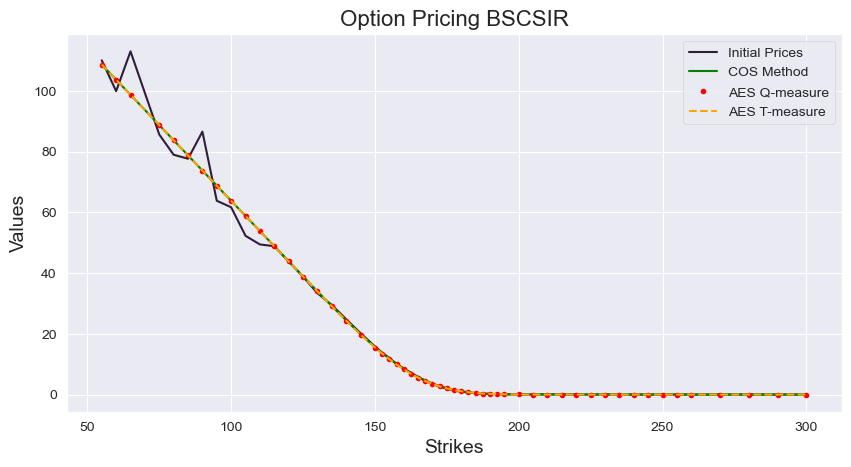

In [37]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(apple_strikes, apple_market_price, label='Initial Prices')
plt.plot(apple_strikes, valCOS, color='green', label='COS Method')
plt.plot(apple_strikes, option_bates_stoch_AES, '.',color='red', label='AES Q-measure')
plt.plot(apple_strikes, option_bates_stoch_AES_Tm, '--',color='orange', label='AES T-measure')
        
plt.title('Option Pricing BSCSIR', fontsize=16)
plt.xlabel('Strikes', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend()
plt.show()

In [38]:
np.mean((option_bates_stoch_AES_Tm - apple_market_price)**2)

9.471033961696047

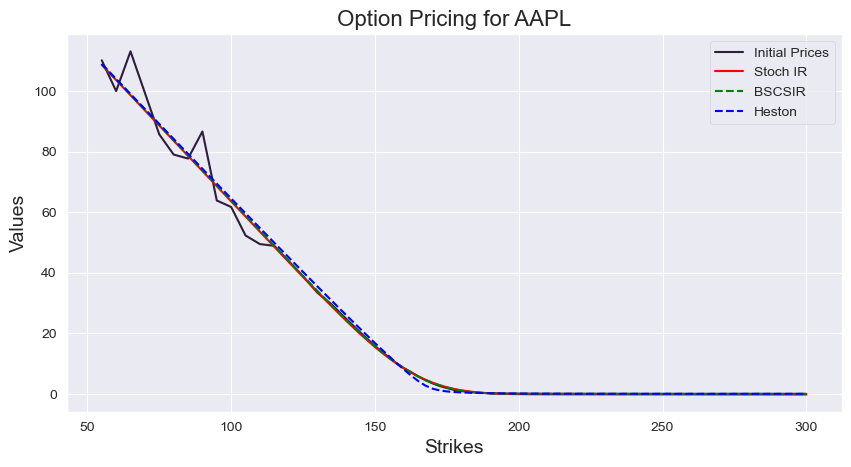

In [60]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(K, apple_market_price, label='Initial Prices')
plt.plot(K, valCOS_H1HW, color='red', label='Stoch IR')
plt.plot(K, valCOS, '--', color='green', label='BSCSIR')
plt.plot(K, option_heston_cos, '--', color='blue', label='Heston')

plt.title('Option Pricing for AAPL', fontsize=16)
plt.xlabel('Strikes', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend()
plt.show()

In [39]:
np.mean((1/M[:, -1]))

0.9999413355097684

In [40]:
zcb0

0.9999412608446564

In [83]:
dt = 0.0001 
P0T = lambda T: np.exp(0.0012*T+0.0007) 
f0T = lambda t: - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2.0*dt)
f0T(0.00001)

-0.0011999999998231958

## BSCSIR AES

In [164]:
def bates_SC_SIR_AES(numberPaths, N, s0, v0, T, k, gamma, vb, kr, gammar, mur, krho, murho, sigmarho, rho4, rho5,
                    xip, muJ, sigmaJ, r0, rho0):
    X = np.zeros([numberPaths, N + 1])
    S = np.zeros([numberPaths, N + 1])
    V = np.zeros([numberPaths, N + 1])
    R = np.zeros([numberPaths, N + 1])
    rho = np.zeros([numberPaths, N + 1])

    M_t = np.ones([numberPaths, N + 1])
    time = np.zeros(N + 1)
    dt = T/float(N)

    Zx = np.random.normal(0, 1, [numberPaths, N])
    Zrho = np.random.normal(0, 1, [numberPaths, N])
    ZP = np.random.poisson(xip*dt, [numberPaths, N])
    J = np.random.normal(muJ, sigmaJ, [numberPaths, N])

    X[:, 0] = np.log(s0)
    V[:, 0] = v0
    rho[:, 0] = rho0
    R[:, 0] = abs(r0)

    EeJ = np.exp(muJ + 0.5 * sigmaJ**2)

    for t in range(N):

        V[:, t+1] = CIR_exact(numberPaths, k, gamma, vb, 0, dt, V[:, t])
        R[:, t+1] = CIR_exact(numberPaths, kr, gammar, mur, 0, dt, R[:, t])
        
        if (R[:, t+1] == 0).any():
            R[np.where(R[:, t+1] == 0)[0], t+1] = 1e-4

        rho[:, t+1] = rho[:, t]*np.exp(-krho*dt) + murho*(1 - np.exp(-krho*dt)) +\
                    sigmarho*np.sqrt((1-np.exp(-2*krho*dt))/(2*krho)) * Zrho[:, t]

        if (rho[:, t+1] > 1).any():
            rho[np.where(rho[:, t+1] > 1)[0], t+1] = 0.9999

        if (rho[:, t+1] < -1).any():
            rho[np.where(rho[:, t+1] < -1)[0], t+1] = -0.9999

        X[:, t+1] = X[:, t] + (R[:, t] - 0.5* V[:, t] - xip*(EeJ-1))*dt + rho[:, t]/gamma * (V[:, t+1] - V[:, t] - k*(vb - V[:, t])*dt) + \
            rho4 * np.sqrt(V[:, t])/sigmarho * (rho[:, t+1] - rho[:, t] - krho*(murho - rho[:, t])*dt) + \
            rho5 * np.sqrt(V[:, t])/(gammar*np.sqrt(R[:, t])) * (R[:, t+1] - R[:, t] - kr*(mur-R[:, t])*dt) +\
            np.sqrt(V[:, t])* np.sqrt(abs(1 - (rho[:, t])**2 - rho4**2 - rho5**2)) * np.sqrt(dt) * Zx[:, t] + J[:, t] * ZP[:, t]

        M_t[:,t+1] = M_t[:,t] * np.exp(0.5*(R[:,t+1] + R[:,t])*dt)
        time[t+1] = time[t] + dt

    S = np.exp(X)

    return time, S, M_t

In [75]:
# v0, k, gamma, vb, kr, gammar, mur, krho, murho, sigmarho, rho4, rho5, muJ, sigmaJ, r0, rho0
numberPaths = 1000
N = 100
T = maturity
type_option = 'c'
# xip = 0.05

def error_BSCSIR_AES(x, prices, K, s0):
    time, S, M = mcm.bates_SC_SIR_AES(numberPaths, N, s0, x[0], T, x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8], x[9], x[10], x[11],
                    x[16], x[12], x[13], x[14], x[15])
    
    price_calib = mcm.optionPriceMC_Stoch(type_option, S[:, -1], K, T, M[:, -1])
    
    return np.mean((price_calib - prices)**2)

init_vals = np.array([0.04, 0.3, 0.04, 0.3, 0.1, 0.2, 0.5, 0.05, 0.4, 0.5, 0.1, 0.1, 0, 1, 0.001, -0.7, 0.05])

xmin = [0.001, 0.0001, 0.0001, 0.0005, 0.001, 0.001, 0.0005, 0.0001, 0.0001, 0.4, -0.89, -0.89, -10, 0.0001, 0.0001, -0.99, 1e-6]
xmax = [1, 0.7, 1.5, 2, 3, 2, 1, 1.7, 4, 2, 0.89, 0.89, 10, 3, 0.3, 0.99, 5]
bounds = [(low, high) for low, high in zip(xmin, xmax)]

params_BSCSIR = minimize(error_BSCSIR_AES, x0=init_vals, args=(marketPrice, K, s0), bounds=bounds, tol=1e-8, options={"maxiter": 100})
params_BSCSIR

      fun: 11.251779596050167
 hess_inv: <17x17 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 23150640.87832325,  31609656.77839144,  24028706.3134479 ,
        -4255819.50082323,  39982519.78387373,  84784650.35199358,
        11902566.77640287, -12171774.50463404,  69934697.65740182,
        51304235.59230111,  19571952.2732274 ,  36097666.47062512,
        24181548.46186216, -10577117.72380085,  62833160.29836688,
        56441168.58544227,  95378328.89300916])
  message: 'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 378
      nit: 0
     njev: 21
   status: 2
  success: False
        x: array([ 0.04 ,  0.3  ,  0.04 ,  0.3  ,  0.1  ,  0.2  ,  0.5  ,  0.05 ,
        0.4  ,  0.5  ,  0.1  ,  0.1  ,  0.   ,  1.   ,  0.001, -0.7  ,
        0.05 ])

In [47]:
v0, k, gamma, vb, kr, gammar, mur, krho, murho, sigmarho, rho4, rho5, muJ, sigmaJ, r0, rho0, xip = params_BSCSIR.x

In [48]:
paths_BSCSIR = mcm.bates_SC_SIR_AES(numberPaths, N, s0, v0, T, k, gamma, vb, kr, gammar, mur, krho, murho, sigmarho, rho4, rho5,
                    xip, muJ, sigmaJ, r0, rho0)

In [49]:
option_BSCSIR_AES = mcm.optionPriceMC_Stoch(type_option, paths_BSCSIR[1][:, -1], K, T, paths_BSCSIR[2][:, -1])

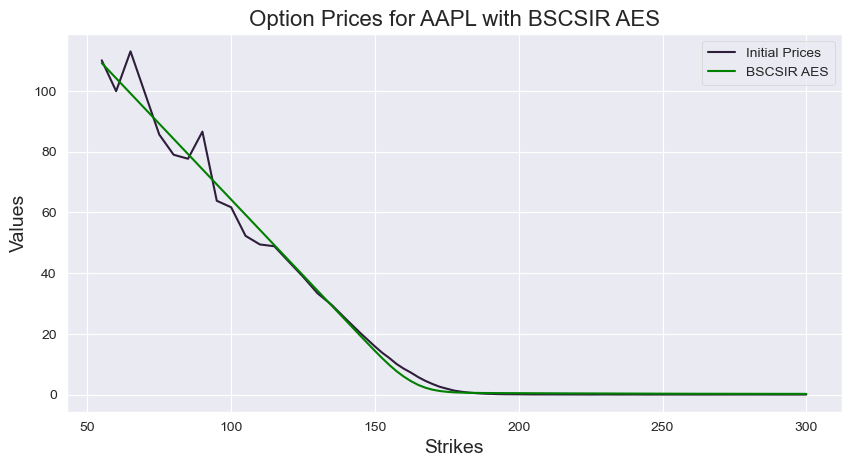

In [50]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(K, marketPrice, label='Initial Prices')
plt.plot(K, option_BSCSIR_AES, color='green', label='BSCSIR AES')
        
plt.title('Option Prices for AAPL with BSCSIR AES', fontsize=16)
plt.xlabel('Strikes', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend()
plt.show()

In [65]:
list_params = np.array([v0, k, gamma, vb, kr, gammar, mur, krho, murho, sigmarho, rho4, rho5, muJ, sigmaJ, r0, rho0, xip])
pd.DataFrame(list_params.reshape(1, -1), columns=['v0', 'k', 'gamma', 'vb', 'kr', 'gammar', 'mur', 'krho', 'murho', 'sigmarho', 'rho4', 'rho5', 'muJ', 'sigmaJ', 'r0', 'rho0', 'xip'])

,v0,k,gamma,vb,kr,gammar,mur,krho,murho,sigmarho,rho4,rho5,muJ,sigmaJ,r0,rho0,xip
0,0.04,0.3,0.04,0.3,0.1,0.2,0.5,0.05,0.4,0.5,0.1,0.1,-3.025808e-07,1.0,0.001,-0.7,0.05


## BSCSIR with stochastic correlation by DCL process 

In [69]:
def calibrationBates_SIR_SC_DCL(CP, xip, K, marketPrice, s0, T):
    K = np.array(K)
    marketPrice = np.array(marketPrice)
   
    # k, gamma, vb, kr, gammar, mur, krho, delta, rho4, rho5, xip, muJ, sigmaJ, v0, r0, rho0
    f_obj = lambda x: errorFun(CP, tau, T, x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8], x[9],
                               x[10], x[11], x[12], x[13], x[14], x[15], K, marketPrice, s0)

                        # k, gamma, vb, kr, gammar, mur, krho, delta, rho4, rho5, xip, muJ, sigmaJ, v0, r0, rho0
    initial = np.array([0.4, 0.3, 0.04, 0.3, 0.2,   0.2,   2,   1.5,  0.1, 0.5, 0.05,  0,    1, 0.04,   0.05, 0.7])

            # k,    gamma,   vb,     kr,   gammar, mur, krho, delta, rho4, rho5,  xip,    muJ, sigmaJ, v0, r0, rho0
    xmin = [0.0001, 0.0001, 0.001, 0.0005, 0.001, 0.0001, 1, 1,     -0.99, -0.99, 0.001, -10,   -10,   0.0001, 0.0001, -0.9999]
    xmax = [5,       0.7,   1.5,     2,      3,     2,   5,  4,      0.98, 0.98,  5,      10, 10,      0.3, 0.3, 0.9999] 
    bounds = [(low, high) for low, high in zip(xmin, xmax)]
    
    minimizer_kwargs = dict(method="L-BFGS-B", bounds=bounds)
    
    pars  = minimize(f_obj, x0=initial, tol=1e-8, bounds=bounds, options = {'maxiter': 200, 'disp':False})
    print(pars)
    
    k_est = pars.x[0]
    gamma_est = pars.x[1]
    vb_est = pars.x[2]
    kr_est = pars.x[3]
    gammar_est = pars.x[4]
    mur_est = pars.x[5]
    krho_est = pars.x[6]
    delta_est = pars.x[7]
    rho4_est = pars.x[8]
    rho5_est = pars.x[9]
    xip_est = pars.x[10]
    muJ_est = pars.x[11]
    sigmaJ_est = pars.x[12]
    v0_est = pars.x[13]
    r0_est = pars.x[14]
    rho0_est = pars.x[15]
   
   
    
    parmCalibr =  {"k":k_est, "gamma":gamma_est, "vb":vb_est, "gammar":gammar_est, "mur":mur_est,\
                   "rho4":rho4_est, "rho5": rho5_est, "v0":v0_est, "kr": kr_est, "krho": krho_est, \
                   "rho0": rho0_est, "r0": r0_est, "muJ": muJ_est, "sigmaJ": sigmaJ_est, "xip": xip_est, "delta": delta_est, 'ErrorFinal':pars.fun}
    return parmCalibr

In [70]:
def errorFun(CP, tau, T, k, gamma, vb, kr, gammar, mur, krho, delta, rho4, rho5, xip, muJ, sigmaJ, v0, r0, rho0, K, marketPrice, s0):
    if K is not np.array:
        K = np.array(K).reshape([len(K),1])

    N = 500
    L = 10
    cf = chf.ChFBates_StochIR_StochCor_DCL(tau, T, k, gamma, vb, kr, gammar, mur, krho, delta, rho4, rho5, xip, muJ, sigmaJ, v0, r0, rho0)
    valCOS = exm.optionPriceCOSMthd_StochIR(cf, CP, s0, T, K, N, L)

    errorVector = np.mean((valCOS.T[0] - marketPrice)**2)
    value = errorVector

    return value

In [71]:
T = maturity
tau = T
type_option = 'c'

# P0T = lambda T: np.exp(0.0005*T)

# dt = 0.0001 
# # P0T = lambda T: np.exp(0.0012*T+0.0007) 
# f0T = lambda t: - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2.0*dt)
# r0 = f0T(0.00001)

K = apple_strikes

marketPrice = apple_market_price

calibratedParms =  calibrationBates_SIR_SC_DCL(type_option, xip, K, marketPrice, s0, T)

k = calibratedParms.get('k')
gamma = calibratedParms.get('gamma')
vb = calibratedParms.get('vb')
gammar = calibratedParms.get('gammar')
mur = calibratedParms.get('mur')
rho4 = calibratedParms.get('rho4')
rho5 = calibratedParms.get('rho5')
v0 = calibratedParms.get('v0')
kr = calibratedParms.get('kr')
krho = calibratedParms.get('krho')
rho0 = calibratedParms.get('rho0')
r0 = calibratedParms.get('r0')
muJ = calibratedParms.get('muJ')
sigmaJ = calibratedParms.get('sigmaJ')
xip = calibratedParms.get('xip')
delta = calibratedParms.get('delta')

errorFinal = calibratedParms.get('ErrorFinal') 

      fun: 9.495094001645041
 hess_inv: <16x16 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.22308393e-01,  1.96399519e-01, -8.72878854e+00, -5.50670621e-06,
       -4.88498131e-05, -8.88178420e-06,  5.32907055e-07,  0.00000000e+00,
        1.77635684e-07, -2.23820962e-05,  5.62412339e-02, -8.04689649e-05,
        2.96829228e-04, -3.14733129e-01, -1.02725828e-01,  1.27897693e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 884
      nit: 28
     njev: 52
   status: 0
  success: True
        x: array([ 7.06402922e-01,  1.00000000e-04,  1.00000038e-03,  3.05285983e-01,
        1.89362201e-01,  1.99909854e-01,  1.99946571e+00,  1.49999882e+00,
        9.98266224e-02,  4.95750759e-01,  1.00000000e-03, -4.65239920e-01,
        4.70862364e-01,  1.56870800e-01,  1.00003978e-04,  4.93624120e-01])


In [72]:
np.sqrt(errorFinal)

3.081411040683317

In [73]:
round(errorFinal, 9)

9.495094002

In [74]:
L = 10
N = 500

cf = chf.ChFBates_StochIR_StochCor_DCL(tau, T, k, gamma, vb, kr, gammar, mur, krho, delta, rho4, rho5, xip, muJ, sigmaJ, v0, r0, rho0)
valCOS_DCL = exm.optionPriceCOSMthd_StochIR(cf, type_option, s0, T, K, N, L)

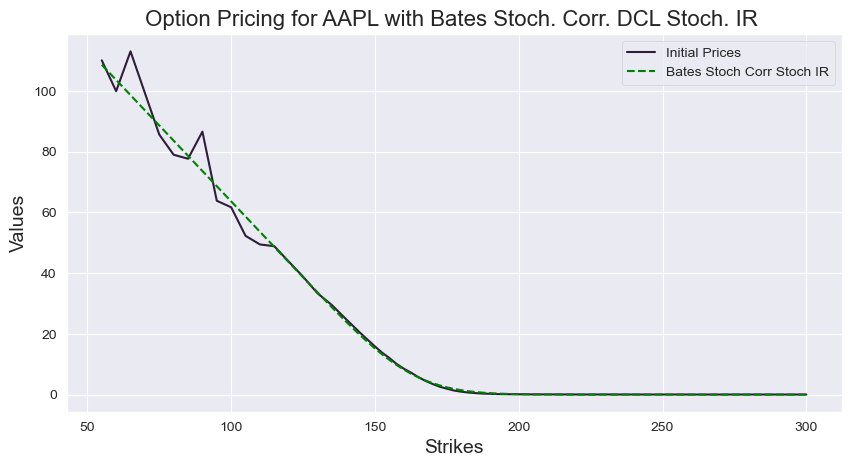

In [75]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(K, marketPrice, label='Initial Prices')
plt.plot(K, valCOS_DCL, '--', color='green', label='Bates Stoch Corr Stoch IR')
        
plt.title('Option Pricing for AAPL with Bates Stoch. Corr. DCL Stoch. IR ', fontsize=16)
plt.xlabel('Strikes', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend()
plt.show()

In [76]:
list_params = np.array([v0, k, gamma, vb, kr, gammar, mur, krho, delta, rho4, rho5, muJ, sigmaJ, r0, rho0, xip])
pd.DataFrame(list_params.reshape(1, -1), columns=['v0', 'k', 'gamma', 'vb', 'kr', 'gammar', 'mur', 'krho', 'delta', 'rho4', 'rho5', 'muJ', 'sigmaJ', 'r0', 'rho0', 'xip'])

,v0,k,gamma,vb,kr,gammar,mur,krho,delta,rho4,rho5,muJ,sigmaJ,r0,rho0,xip
0,0.156871,0.706403,0.0001,0.001,0.305286,0.189362,0.19991,1.999466,1.499999,0.099827,0.495751,-0.46524,0.470862,0.0001,0.493624,0.001


In [14]:
# v0, k, gamma, vb, kr, gammar, mur, theta, delta, rho4, rho5, muJ, sigmaJ, r0, rho0, xip
numberPaths = 10000
N = 100
T = maturity
type_option = 'c'

def error_BSCSIR_DCL_AES(x, prices, K, s0):
    time, S, M = mcm.bates_SC_SIR_DCL_AES(numberPaths, N, s0, x[0], T, x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8], x[9], x[10], x[15],
                    x[11], x[12], x[13], x[14])
    
    price_calib = mcm.optionPriceMC_Stoch(type_option, S[:, -1], K, T, M[:, -1])
    
    return np.mean((price_calib - prices)**2)

init_vals = np.array([0.04, 0.3, 0.04, 0.3, 0.1, 0.2, 0.5, 0.1, 1, 0.1, 0.1, 0, 1, 0.001, -0.7, 0.05])

xmin = [0.001, 0.0001, 0.0001, 0.0005, 0.001, 0.001, 0.0005, 0.1, 1, -0.89, -0.89, -10, 0.0001, 0.0001, -0.99, 1e-5]
xmax = [1, 0.7, 1.5, 2, 3, 2, 1, 5, 3, 0.89, 0.89, 10, 3, 0.3, 0.99, 5]
bounds = [(low, high) for low, high in zip(xmin, xmax)]

params_BSCSIR_DCL = minimize(error_BSCSIR_DCL_AES, x0=init_vals, args=(marketPrice, K, s0), bounds=bounds, tol=1e-4, options={"maxiter": 1000})
params_BSCSIR_DCL

/Users/kirillzakharov/Desktop/Stochastic Calculus/monte_carlo_methods.py:281: RuntimeWarning: overflow encountered in exp
  S = np.exp(X)
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: 10.834427266484848
 hess_inv: <16x16 LbfgsInvHessProduct with dtype=float64>
      jac: array([   172170.17392401,   2735205.00621163,  19119142.4653461 ,
        -8881668.6523633 ,   4649002.91733176, -17886396.99867317,
        42285340.88238665,  11731661.63356522,  25517462.97089129,
        -4583262.16147262,  23595241.68421024,   8396894.69406232,
        28669784.41241259,   1433638.46391543, -17268019.53506413,
         1605694.05013284])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 544
      nit: 5
     njev: 32
   status: 0
  success: True
        x: array([ 3.99999898e-02,  2.99999922e-01,  3.99999896e-02,  2.99999922e-01,
        9.99999742e-02,  1.99999948e-01,  5.00000130e-01,  1.00000000e-01,
        1.00000000e+00,  9.99997417e-02,  9.99997417e-02, -2.60909091e-06,
        9.99999739e-01,  9.99999765e-04, -6.99999559e-01,  4.99999870e-02])

In [15]:
v0, k, gamma, vb, kr, gammar, mur, theta, delta, rho4, rho5, muJ, sigmaJ, r0, rho0, xip = params_BSCSIR_DCL.x

In [16]:
paths_BSCSIR_DCL = mcm.bates_SC_SIR_DCL_AES(numberPaths, N, s0, v0, T, k, gamma, vb, kr, gammar, mur, theta, delta, rho4, rho5,
                    xip, muJ, sigmaJ, r0, rho0)

In [17]:
option_BSCSIR_DCL_AES = mcm.optionPriceMC_Stoch(type_option, paths_BSCSIR_DCL[1][:, -1], K, T, paths_BSCSIR_DCL[2][:, -1])

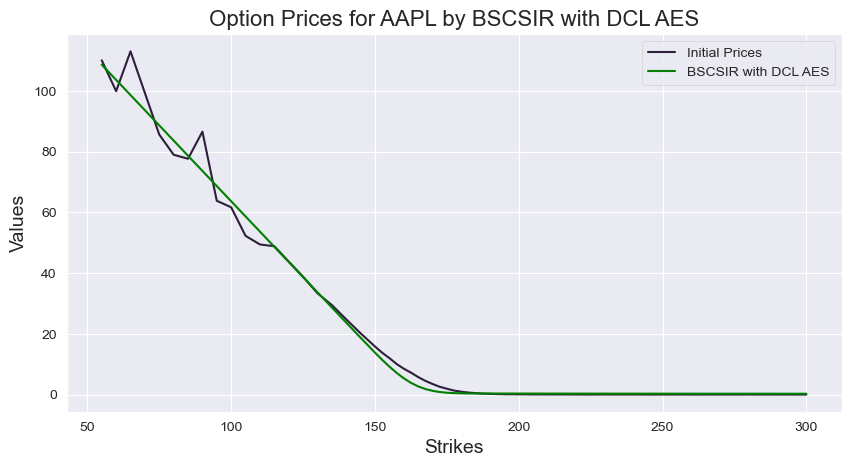

In [18]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(K, marketPrice, label='Initial Prices')
plt.plot(K, option_BSCSIR_DCL_AES, color='green', label='BSCSIR with DCL AES')
        
plt.title('Option Prices for AAPL by BSCSIR with DCL AES', fontsize=16)
plt.xlabel('Strikes', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend()
plt.show()

In [103]:
tsla = ops.get_calls("TSLA", 'May 13, 2022')

In [111]:
# tsla.to_csv('tsla_option_call_may_13_2022.csv')

In [115]:
# s0_tsla = 766.37 #15.03.2022
tslaticker = yf.Ticker('TSLA')
s0_tsla = tslaticker.history().iloc[-1, 3]
s0_tsla

975.9299926757812

In [116]:
tsla_strikes = tsla.loc[:, 'Strike']
tsla_market_price = tsla.loc[:, 'Last Price']

In [117]:
tsla.head()

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility
0,TSLA220513C00200000,2022-04-05 12:27PM EDT,200.0,891.75,0.0,0.0,0.0,-,-,3,0.00%
1,TSLA220513C00780000,2022-04-06 11:13AM EDT,780.0,269.34,0.0,0.0,0.0,-,-,1,0.00%
2,TSLA220513C00800000,2022-04-06 2:36PM EDT,800.0,261.15,0.0,0.0,0.0,-,-,2,0.00%
3,TSLA220513C00810000,2022-04-11 10:24AM EDT,810.0,203.83,0.0,0.0,0.0,-,4,4,0.00%
4,TSLA220513C00820000,2022-04-11 11:28AM EDT,820.0,182.77,0.0,0.0,0.0,-,4,9,0.00%


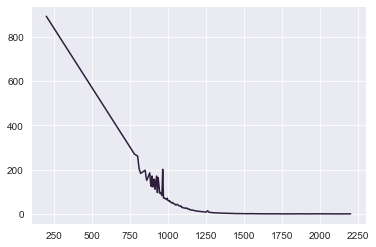

In [118]:
plt.plot(tsla_strikes, tsla_market_price)
plt.show()

In [11]:
from datetime import datetime

In [137]:
expr_date = datetime.strptime('May 13, 2022', '%B %d, %Y')
expr_date

datetime.datetime(2022, 5, 13, 0, 0)

In [138]:
today_date = datetime.now()
today_date

datetime.datetime(2022, 4, 12, 15, 52, 13, 314673)

In [139]:
maturity = expr_date - today_date
maturity = maturity.days/365.25
maturity

0.08213552361396304

In [140]:
(expr_date - today_date).days

30

In [176]:
N = 500
T = maturity
r = 0.01
rho1 = 0.2
s0 = s0_tsla

type_option = 'c'
# type_option = 'p'

In [177]:
# r, kappa, gamma, vbar, v0, rho

def error_fHM(x, prices, strikes, s0):
    cf = chf.ChFHestonModel(x[0], 1, x[1], x[2], x[3], x[4], x[5])
    
    price_calib = exm.CallPutOptionPriceCOS(cf, type_option, s0, x[0], T, strikes, N, 8).T[0]
#     errorVector = (price_calib - prices)
    errorVector = np.mean(((price_calib - prices))**2)
    
#     value = np.linalg.norm(errorVector)
    value = errorVector
    return value

In [178]:
init_vals = [0.05, 2, 0.3, 0.4, 0.3, -0.7]
bounds = ((0.001, 0.3), (0.001, 4), (0.0001, 2), (0.0001, 1.5), (0.0001, 1.5), (-0.9, 0.9))

# P0T = lambda T: np.exp(0.0012*T+0.0007) 
# s0 = 174.62

# referenceIV = np.array([48.53, 24.49, 19.23])/100.0
        
# T = 5/365.25
# referenceIV = np.array([36.76, 29.18, 27.66])/100.0
    
# frwd = s0/P0T(T)
# K = [0.4*frwd, frwd, 1.2*frwd]
# K = np.array(K).reshape([len(K),1])
      
# referenceIV = np.array(referenceIV).reshape([len(referenceIV),1])
# marketPrice = P0T(T)* exm.BS_Call_Option_Price('c', s0 / P0T(T), K, referenceIV, T, 0)


# params_heston_COS = minimize(error_fHM, x0=init_vals, args=(apple_market_price, apple_strikes, s0_apple, apple_spread),
#                              bounds=bounds, tol=1e-4, options={"maxiter": 1000})

K = tsla_strikes
marketPrice = tsla_market_price

params_heston_COS = minimize(error_fHM, x0=init_vals, args=(marketPrice, K, s0),
                             bounds=bounds, tol=1e-4, options={"maxiter": 1000})

params_heston_COS

      fun: 283.90085873956417
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([-61.2943836 ,  24.7909553 , -10.6235462 , 240.83846041,
       436.39720381,  -5.74447086])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 140
      nit: 15
     njev: 20
   status: 0
  success: True
        x: array([ 0.04357717,  0.80291941,  1.32503566,  0.10917969,  0.01945136,
       -0.49928127])

In [179]:
np.sqrt(params_heston_COS.fun)

16.849357813862348

In [180]:
r, kappa, gamma, vbar, v0, rho = params_heston_COS.x

In [181]:
cf = chf.ChFHestonModel(r, 1, kappa, gamma, vbar, v0, rho)
option_heston_cos = exm.CallPutOptionPriceCOS(cf, type_option, s0, r, T, K, N, 10).T[0]

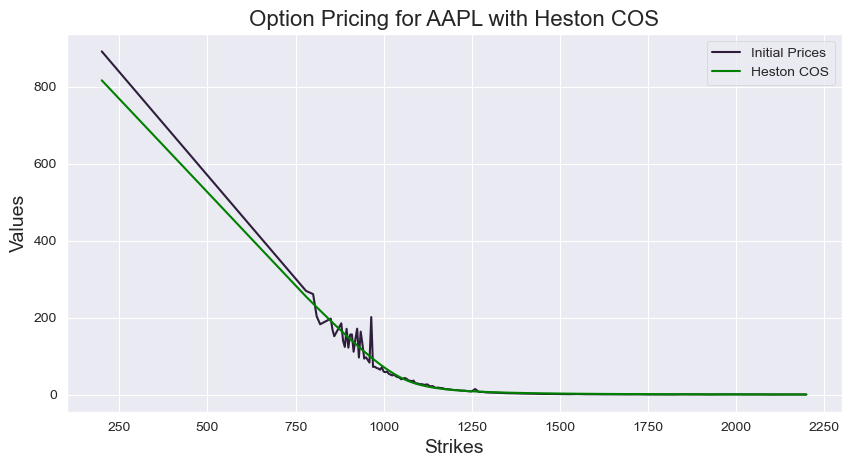

In [182]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(K, marketPrice, label='Initial Prices')
plt.plot(K, option_heston_cos, color='green', label='Heston COS')
        
plt.title('Option Pricing for AAPL with Heston COS', fontsize=16)
plt.xlabel('Strikes', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend()
plt.show()

In [183]:
T = maturity
tau = T

xip = 1
type_option = 'c'

P0T = lambda T: np.exp(0.05*T)

# dt = 0.0001 
# # P0T = lambda T: np.exp(0.0012*T+0.0007) 
# f0T = lambda t: - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2.0*dt)
# r0 = f0T(0.00001)


K = tsla_strikes

marketPrice = tsla_market_price

calibratedParms =  calibrationBates_SIR_SC(type_option, xip, K, marketPrice, s0, T, P0T)

k = calibratedParms.get('k')
gamma = calibratedParms.get('gamma')
vb = calibratedParms.get('vb')
gammar = calibratedParms.get('gammar')
mur = calibratedParms.get('mur')
murho = calibratedParms.get('murho')
sigmarho = calibratedParms.get('sigmarho')
rho4 = calibratedParms.get('rho4')
rho5 = calibratedParms.get('rho5')
v0 = calibratedParms.get('v0')
kr = calibratedParms.get('kr')
krho = calibratedParms.get('krho')
rho0 = calibratedParms.get('rho0')
r0 = calibratedParms.get('r0')
muJ = calibratedParms.get('muJ')
sigmaJ = calibratedParms.get('sigmaJ')

errorFinal = calibratedParms.get('ErrorFinal') 

      fun: 334.0854693271909
 hess_inv: <16x16 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.09894325e-01, -1.78306436e-01,  1.35173479e+01, -5.51381163e-03,
        3.58113539e-04, -1.06297193e-03, -3.69482223e-04,  1.53477231e-03,
       -7.34985406e-03,  1.04842684e+01,  8.24229574e-04, -2.33058017e-03,
       -8.19852626e-02, -4.49006166e-02, -9.86176480e-02, -2.63969467e+00])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 493
      nit: 23
     njev: 29
   status: 0
  success: True
        x: array([ 1.31651407e+00,  1.33218480e-01,  2.21763977e-02,  2.91902832e-01,
        9.72626577e-02,  1.61862735e-01,  4.62529586e-01, -1.09187943e-01,
        7.49064028e-02,  1.02161130e-03,  4.01045298e-01,  4.81361536e-01,
       -7.34367716e-01,  1.20564163e-01, -1.92715023e+00,  8.63237513e-01])


In [184]:
np.sqrt(errorFinal)

18.278005069678443

In [185]:
round(errorFinal, 9)

334.085469327

In [186]:
L = 10
N = 500

cf = chf.ChFBates_StochIR_StochCor(tau, T, k, gamma, vb, kr, gammar, mur, krho, murho, sigmarho, rho4, rho5, xip, muJ, sigmaJ, v0, r0, rho0)
valCOS = exm.optionPriceCOSMthd_StochIR(cf, type_option, s0, T, K, N, L, P0T(T))

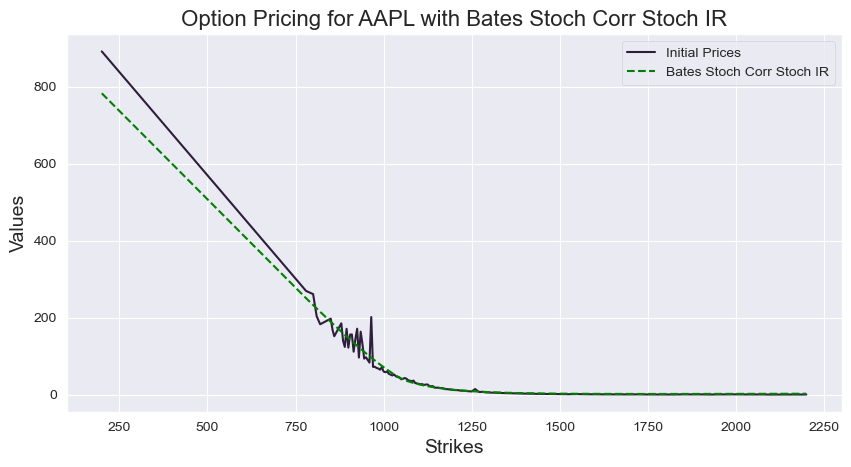

In [187]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(K, marketPrice, label='Initial Prices')
plt.plot(K, valCOS, '--', color='green', label='Bates Stoch Corr Stoch IR')
        
plt.title('Option Pricing for AAPL with Bates Stoch Corr Stoch IR', fontsize=16)
plt.xlabel('Strikes', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend()
plt.show()

In [188]:
zcb0 = zcb_curve(tau, kr, mur, gammar, r0)
zcb0

0.9901780552843185

In [190]:
K*zcb0 + s0 

0      1173.965604
1      1748.268876
2      1768.072437
3      1777.974217
4      1787.875998
          ...     
110    3030.549457
111    3055.303909
112    3080.058360
113    3129.567263
114    3154.321714
Name: Strike, Length: 115, dtype: float64

In [193]:
#Zero-coupon parity
def optionPriceCOSMthd_StochIR(cf, CP, s0,tau,K,N,L,P0T):
    if K is not np.array:
        K = np.array(K).reshape([len(K),1])

    i = complex(0.0,1.0)
    x0 = np.log(s0 / K)

    # Truncation domain
    a = 0.0 - L * np.sqrt(tau)
    b = 0.0 + L * np.sqrt(tau)

    # Summation from k = 0 to k=N-1
    k = np.linspace(0,N-1,N).reshape([N,1])
    u = k * np.pi / (b - a)

    H_k = exm.Hk_Coefficients('p',a,b,k)
    mat = np.exp(i * np.outer((x0 - a) , u))
    temp = cf(u) * H_k
    temp[0] = 0.5 * temp[0]
    value = K * np.real(mat.dot(temp))
        
    if CP == 'c':
        value = value + s0 - K * P0T  

    return value

In [194]:
L = 10
N = 500

cf = chf.ChFBates_StochIR_StochCor(tau, T, k, gamma, vb, kr, gammar, mur, krho, murho, sigmarho, rho4, rho5, xip, muJ, sigmaJ, v0, r0, rho0)
valCOS = optionPriceCOSMthd_StochIR(cf, type_option, s0, T, K, N, L, zcb0)

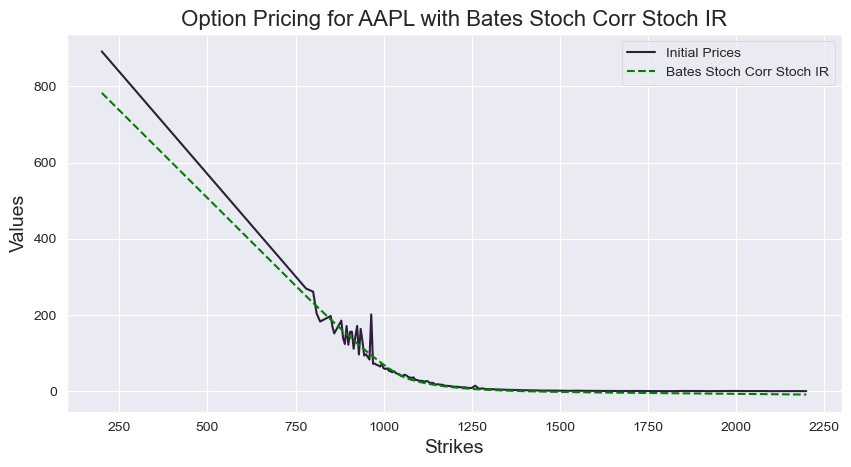

In [195]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(K, marketPrice, label='Initial Prices')
plt.plot(K, valCOS, '--', color='green', label='Bates Stoch Corr Stoch IR')
        
plt.title('Option Pricing for AAPL with Bates Stoch Corr Stoch IR', fontsize=16)
plt.xlabel('Strikes', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend()
plt.show()